In [1]:
# Importar bibliotecas necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
# Definir parámetros de la red y del entrenamiento
EPOCHS = 100
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 1000
LEARNING_RATE = 1e-4

In [3]:
# Montar Google Drive si estás utilizando Colab
from google.colab import drive
drive.mount('/content/drive')

# Directorio de imágenes
images_dir = '/content/drive/My Drive/last_data'

Mounted at /content/drive


In [4]:
# Obtener las clases y asignar etiquetas numéricas
class_names = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

print(f"Clases encontradas: {class_names}")

Clases encontradas: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


In [5]:
# Crear listas para almacenar rutas y etiquetas
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(images_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_label[class_name])

# Crear el DataFrame
data_df = pd.DataFrame({
    'filepath': image_paths,
    'label': labels
})

print(f"Distribución original de clases:\n{data_df['label'].value_counts()}")

Distribución original de clases:
label
3    1161
4     907
2     846
0     825
1     569
Name: count, dtype: int64


In [6]:
# Dividir en entrenamiento y validación
train_df, val_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df['label'],
    random_state=SEED
)

print(f"Distribución de clases en entrenamiento:\n{train_df['label'].value_counts()}")
print(f"Distribución de clases en validación:\n{val_df['label'].value_counts()}")

Distribución de clases en entrenamiento:
label
3    929
4    725
2    677
0    660
1    455
Name: count, dtype: int64
Distribución de clases en validación:
label
3    232
4    182
2    169
0    165
1    114
Name: count, dtype: int64


In [7]:
# Calcular los pesos de clase
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))
print(f"Pesos de clase: {class_weights}")


Pesos de clase: {0: 1.0442424242424242, 1: 1.5147252747252746, 2: 1.0180206794682423, 3: 0.7418729817007536, 4: 0.9506206896551724}


In [8]:
# Definir data augmentation mejorada
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

In [9]:
# Función para cargar y preprocesar las imágenes
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    # Preprocesamiento específico para MobileNetV2
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Función para extraer rutas y etiquetas del DataFrame
def path_to_image_label(df):
    return df['filepath'].values, df['label'].values


In [10]:
# Extraer rutas y etiquetas
train_paths, train_labels = path_to_image_label(train_df)
val_paths, val_labels = path_to_image_label(val_df)

# Crear TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# Aplicar la función de preprocesamiento
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# Definir las entradas del modelo
inputs = Input(shape=INPUT_SHAPE)


In [12]:
# Modelos base con fine-tuning
# Modelo base 1: MobileNetV2
base_model_mobilenet = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = True  # Permitir fine-tuning
# Descongelar las últimas 20 capas
for layer in base_model_mobilenet.layers[:-20]:
    layer.trainable = False

x1 = base_model_mobilenet(inputs)
x1 = GlobalAveragePooling2D()(x1)
x1 = BatchNormalization()(x1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Modelo base 2: ResNet50
base_model_resnet = ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model_resnet.trainable = True
for layer in base_model_resnet.layers[:-20]:
    layer.trainable = False

x2 = base_model_resnet(inputs)
x2 = GlobalAveragePooling2D()(x2)
x2 = BatchNormalization()(x2)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Modelo base 3: EfficientNetB0
base_model_efficientnet = EfficientNetB0(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model_efficientnet.trainable = True
for layer in base_model_efficientnet.layers[:-20]:
    layer.trainable = False

x3 = base_model_efficientnet(inputs)
x3 = GlobalAveragePooling2D()(x3)
x3 = BatchNormalization()(x3)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Concatenar las salidas de los tres modelos
combined = Concatenate()([x1, x2, x3])


In [16]:
# Agregar capas densas adicionales con regularización y dropout
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)


In [17]:
# Crear el modelo final
ensemble_model = Model(inputs=inputs, outputs=outputs)

# Compilar el modelo con un learning rate reducido
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['accuracy'])


In [18]:
# Resumen del modelo
ensemble_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4608)           │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)    

 Total params: 31,128,680 (118.75 MB)

 Trainable params: 12,711,797 (48.49 MB)

 Non-trainable params: 18,416,883 (70.25 MB)

In [19]:
# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

checkpoint_path = 'best_ensemble_model.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

tensorboard_log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [20]:
# Entrenamiento del modelo de ensamble con pesos de clase
history = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
)


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3494 - loss: 8.6193
Epoch 1: val_loss improved from inf to 7.68697, saving model to best_ensemble_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 915s 6s/step - accuracy: 0.3501 - loss: 8.6159 - val_accuracy: 0.4350 - val_loss: 7.6870 - learning_rate: 1.0000e-04
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5641 - loss: 7.6381
Epoch 2: val_loss improved from 7.68697 to 7.38025, saving model to best_ensemble_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 954ms/step - accuracy: 0.5644 - loss: 7.6370 - val_accuracy: 0.6497 - val_loss: 7.3802 - learning_rate: 1.0000e-04
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6963 - loss: 7.1054
Epoch 3: val_loss improved from 7.38025 to 7.08216, saving model to best_ensemble_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 139s 925ms/step - accuracy: 0.6963 - loss: 7.1053 - val_accuracy: 0.6995 - val_loss: 7.0822 - learning_rate: 1.0000e-04
Epoch 4/100
10

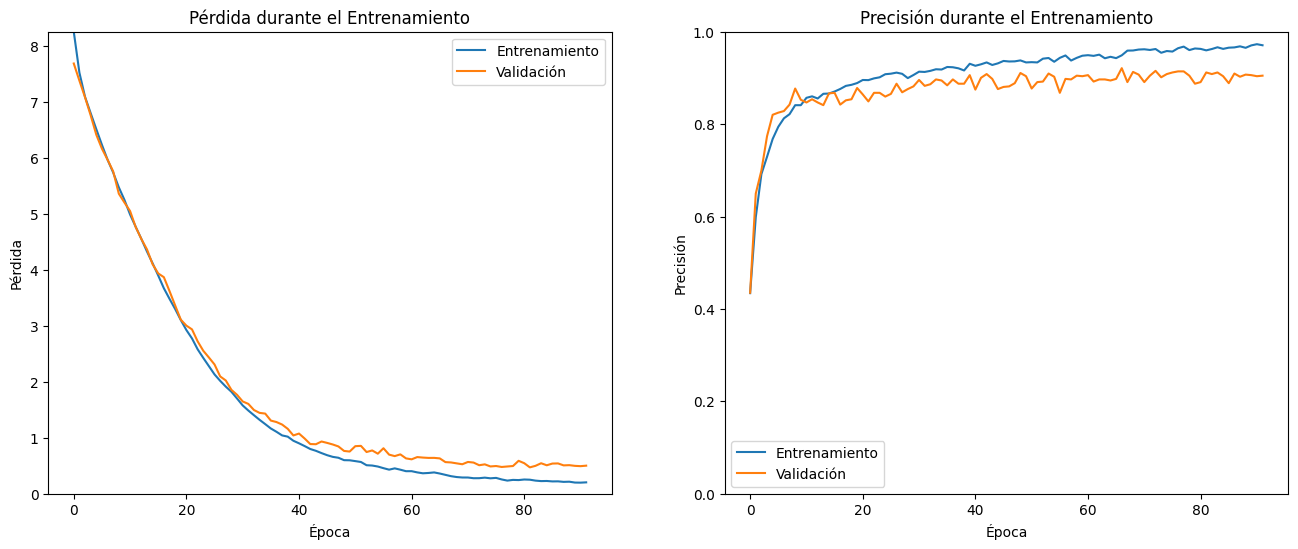

In [21]:
# Gráfica de la pérdida y precisión
metrics = history.history
plt.figure(figsize=(16, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Entrenamiento')
plt.plot(history.epoch, metrics['val_loss'], label='Validación')
plt.legend()
plt.ylim([0, max(metrics['loss'] + metrics['val_loss'])])
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.title('Pérdida durante el Entrenamiento')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Entrenamiento')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validación')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.title('Precisión durante el Entrenamiento')

plt.show()

In [22]:
# Evaluar el modelo en el conjunto de validación
val_results = ensemble_model.evaluate(val_ds, return_dict=True)
print("Resultados de evaluación en el conjunto de validación:")
for metric, value in val_results.items():
    print(f"{metric}: {value:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 619ms/step - accuracy: 0.9103 - loss: 0.5102
Resultados de evaluación en el conjunto de validación:
accuracy: 0.9060
loss: 0.5013


In [23]:
# Obtener predicciones
y_pred_probs = ensemble_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


In [24]:
# Obtener etiquetas verdaderas
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [25]:
# Calcular la matriz de confusión
conf_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()

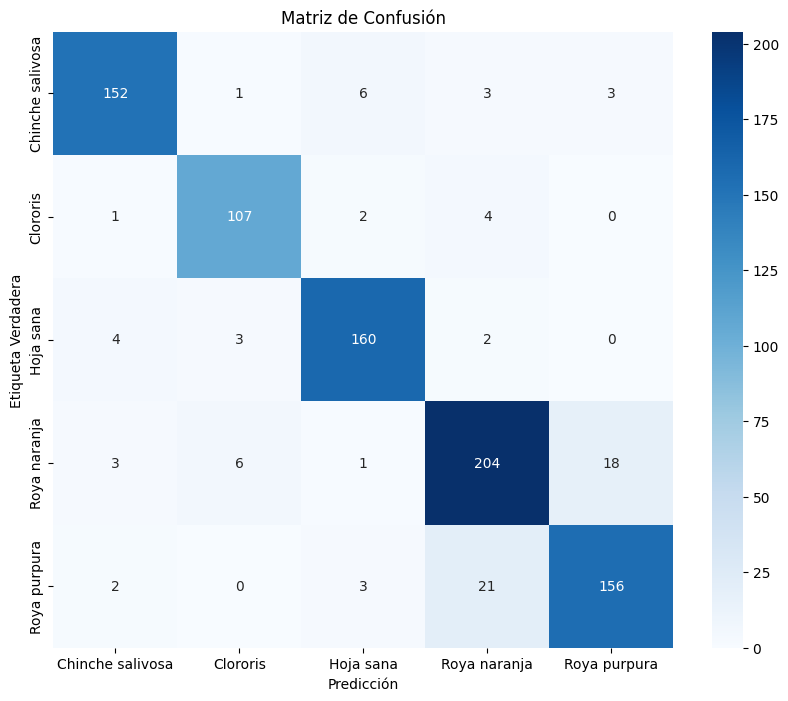

In [26]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [27]:
# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.94      0.92      0.93       165
        Clororis       0.91      0.94      0.93       114
       Hoja sana       0.93      0.95      0.94       169
    Roya naranja       0.87      0.88      0.88       232
    Roya purpura       0.88      0.86      0.87       182

        accuracy                           0.90       862
       macro avg       0.91      0.91      0.91       862
    weighted avg       0.90      0.90      0.90       862

